# ICNet: A deep neural network model of central auditory processing
This Jupyter notebook provides a simple usage example for ICNet. Any sound input can be loaded from a wavfile (wavfile_path) and calibrated at a desired level (sound_level) to simulate neural activity in the IC. ICNet transforms the provided sound input (sampled at 24414.0625 Hz) into a neural activity response sampled at 762.9395 Hz. The derived neural response can be adjusted using output_to_simulate. 

Fotios Drakopoulos, UCL, June 2024

In [1]:
# Define whether to use a GPU for executing the model
# CPU is used by default (empty string)
GPU = "" # set to a number to use a specific GPU (if available)
# Set the CPU/GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress warnings

## Import packages/dependencies

In [2]:
import tensorflow_probability as tfp
import tensorflow as tf
from platform import python_version

print('Python Version: ', python_version())
print('TF Version: ', tf.__version__)
print('TF Probability Version: ', tfp.__version__)

# Add to the path the src folder which contains the functions needed to construct the DNN network
import sys
sys.path.append('src')
from ICNet_functions import *
# Extra packages to import
import yaml
from time import time
import librosa
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

Python Version:  3.11.7
TF Version:  2.13.1
TF Probability Version:  0.21.0


In [3]:
## Sound input
# Defines the path of a sound file to use as input
wavfile_path = './scribe_male_talker.wav'
# Sound intensity in dB SPL - used to calibrate the sound input
sound_level = 70
# Frame size to simulate the input in windows (e.g. 8192 samples)
window_size = 0 # if 0, then the whole sound signal is used
## ICNet model
# Directory with the ICNet model weights
model_path = 'DNN'
## ICNet response
# Define the output to simulate - can be one of the following:
# 'units_N': N units selected from all animals to achieve a uniform logarithmic spacing of CFs between CF_min and CF_max (defined below) - N = {1,...,4446} 
# 'animal_random' or 'animal_X': neural activity of a random animal (or a given animal X = {1,...,9}) 
# 'bottleneck': the response of the ICNet bottleneck
output_to_simulate = 'units_1000' # simulate 1000 units from all animals
# Recording time input for the ICNet model - can be set to anything between 0 and 11 hours to provide a stationary output
time_input = 7200 # given in seconds - default is 2 hours (7200 s) for simulating non-stationary responses

In [4]:
# Read the CFs of all units - inf values correspond to bad channels (low test-retest reliability)
# When provided, this array is used to sort neural units by CFs
unit_CFs = sp_io.loadmat(model_path + '/channel_CFs.mat')
unit_CFs = unit_CFs['channel_CFs'][0]
# Define the frequency range for the logarithmic spacing (only used when output_to_simulate='units_N')
CF_min = 300 # Hz - minimum CF across all animals is ~300 Hz
CF_max = 12000 # Hz - maximum CF across all animals is ~16 kHz

In [5]:
# Load the dictionary that contains all fixed model parameters - see the config.yaml file for more details
with open(model_path + '/config.yaml', 'r') as file:
    params = yaml.load(file, Loader=yaml.FullLoader)
    # print(params)
# Extract some of the parameters for convenience
p0 = params['p0'] # dB SPL reference is 2e-5 Pa
fs_audio = params['fs_audio'] # sampling frequency of the audio input is 24414.0625 Hz
fs_MUA = params['fs_MUA'] # sampling frequency of the neural activity output is 762.939453125 Hz (fs_audio / 32)
context_size = params['context_size'] # context to be added to the audio input (2048 samples)

In [6]:
# # Fix the random seeds
# np.random.seed(settings.data.seed)
# tf.random.set_seed(settings.data.seed)

## Prepare the audio input

In [7]:
# Read the wavfile and resample to the model sampling frequency
audio_input, _ = wavfile_read(wavfile_path, fs_audio) # if an fs argument is provided, the wavfile gets resampled
# Calibrate to the desired sound level
audio_input = p0 * 10**(sound_level/20) * audio_input / rms(audio_input)
# Add context, segment to windows (if needed) and reshape into a 3D array
audio_input = slice_1dsignal(audio_input, window_size, winshift = window_size, left_context = context_size)
# The audio input needs to be a multiple of 32
if audio_input.shape[1] % 32:
    audio_input = pad_along_1dimension(audio_input,0,32 - (audio_input.shape[1] % 32), axis=1) # right padding with zeros

## Simulate the ICNet responses

In [8]:
time_elapsed = time()
# Get the model responses (and CFs)
ICNet_response, response_CFs = simulate_model_responses(model_path, audio_input, output_to_simulate, time_input, 
                                          channel_CFs=unit_CFs, CF_min=CF_min, CF_max=CF_max, **params)
time_elapsed = time() - time_elapsed
print('Simulation finished in ' + '%.2f' % time_elapsed + ' s')

2024-06-16 16:37:08.060596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Simulation finished in 16.56 s


In [9]:
# Remove the context from the audio input and reshape to a 1D array
audio = audio_input[:,context_size:].flatten()
# Reshape the ICNet response across time to get a 2D matrix
output_channels = ICNet_response.shape[-1]
ICNet_response = np.reshape(ICNet_response, (-1,output_channels))
# Define the time arrays
t_audio = np.arange(0., audio.size/fs_audio, 1./fs_audio)
t_MUA = np.arange(0., ICNet_response.shape[0]/fs_MUA, 1./fs_MUA)

## Plot the IC neural activity

In [10]:
# Time range to plot
time_range = [20.5,21.5] # seconds

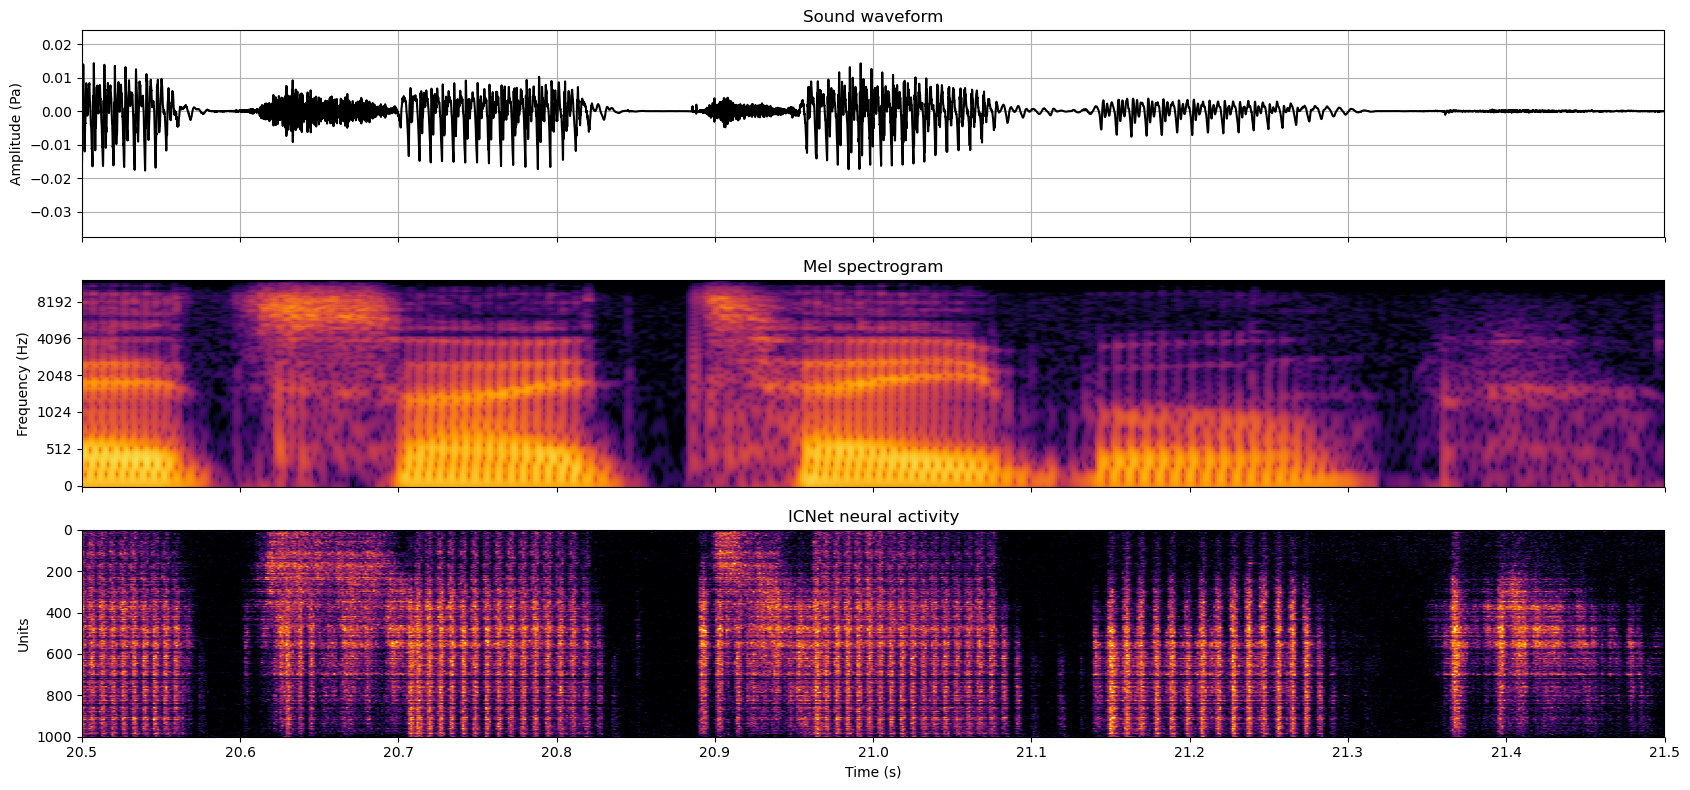

In [11]:
f, ax = plt.subplots(3,figsize=(17,8), sharex=True)
# Sound waveform
ax[0].set_title('Sound waveform')
ax[0].plot(t_audio,audio,'k')
ax[0].grid();
ax[0].set_ylabel('Amplitude (Pa)')

# Mel spectrogram
ax[1].set_title('Mel spectrogram')
melspec = librosa.feature.melspectrogram(y=audio, sr=fs_audio, n_fft=1024, hop_length=32, win_length=256, n_mels=128, fmin=50, fmax=12000)
melspec = librosa.power_to_db(melspec, ref = p0 ** 2, top_db = 100)
img = librosa.display.specshow(melspec, sr=fs_audio, hop_length=32, cmap='inferno', ax=ax[1], x_axis='time', y_axis='mel');
ax[1].set_xlabel('')
ax[1].set_ylabel('Frequency (Hz)')
# f.colorbar(img, ax=ax[1], format="%2.f dB SPL", fraction=0.05) # colorbar

# ICNet response
ax[2].set_title('ICNet neural activity')
if 'bottleneck' in output_to_simulate:
    img = ax[2].imshow(ICNet_response.T, aspect='auto', extent=[0,t_MUA[-1],output_channels,0], origin='lower', cmap='inferno')
    ax[2].set_ylabel('Channels')
else:
    img = ax[2].imshow(ICNet_response.T, aspect='auto', extent=[0,t_MUA[-1],output_channels,0], origin='lower', cmap='inferno', vmin=0, vmax=3)
    ax[2].set_ylabel('Units')
# f.colorbar(img, ax=ax[2], format="%d spikes", ticks=range(5)) # colorbar

ax[2].set_xlabel('Time (s)')
ax[2].xaxis.set_major_formatter(ScalarFormatter())
if len(time_range):
    ax[2].set_xlim(time_range)

f.tight_layout();

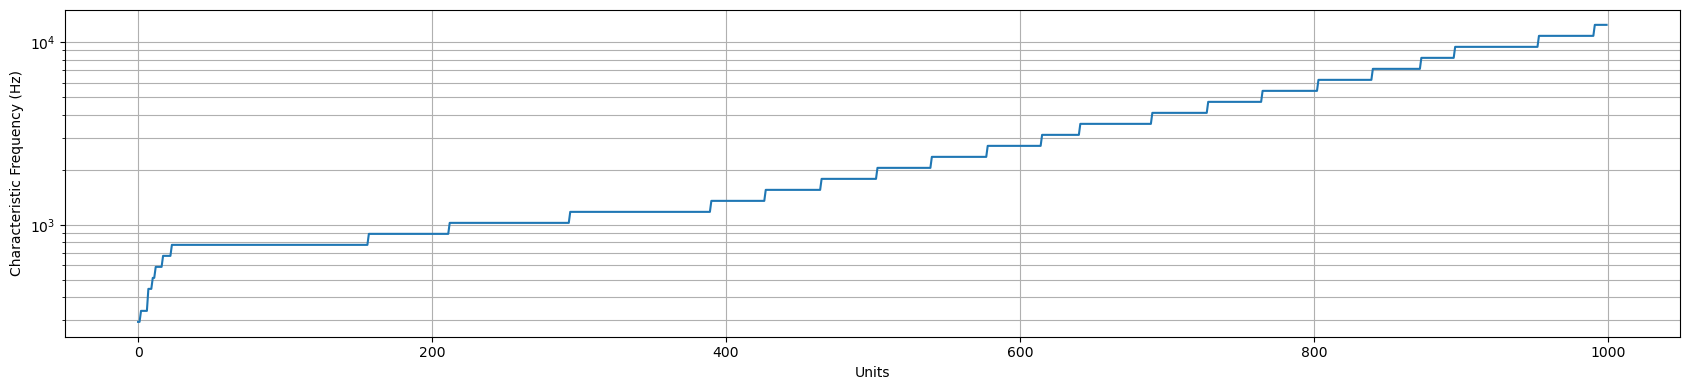

In [12]:
# Plot the CFs of the simulated neural units (if channel_CFs is provided)
if np.any(response_CFs): # ensure that array is not empty
    f = plt.figure(figsize=(17,4))
    plt.semilogy(response_CFs)
    plt.xlabel('Units')
    plt.ylabel('Characteristic Frequency (Hz)')
    plt.grid(which='both');
    f.tight_layout();